# Mixture distributions

In [1]:
from IPython import get_ipython

if get_ipython():
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")

import numpy as np
import pandas as pd
import seaborn as sns
import scipy

import latenta as la

## Generative model

In [2]:
n_cells = 500
cell_ids = [str(i) for i in range(n_cells)]

cells = la.Dim(pd.Series(cell_ids, name="cell"))

x_value = pd.Series(np.random.uniform(0, 5, n_cells), index=cells.index)
x = la.Fixed(x_value, label="x")

In [3]:
distributions_gs = {
    "a": la.distributions.Normal(5.0, 1.0),
    "b": la.distributions.Laplace(-1.0, 1.0),
    "c": la.distributions.Normal(10.0, 1.0),
}
distributions_dim = la.Dim(list(distributions_gs.keys()), "distribution")

In [4]:
w = pd.DataFrame(
    np.vstack([x_value * 2, np.sqrt(x_value), 2 * (x_value - 3) ** 2]),
    index=distributions_dim.index,
    columns=cells.index,
).T
w = w / w.sum(1).values[:, None]
w = la.Fixed(w)

In [5]:
mixture = la.distributions.Mixture(
    distributions=distributions_gs, weight=w, label="mixture"
)

In [6]:
mixture.plot()

In [7]:
model_gs = la.Root(mixture)
x_gs = x

In [8]:
posterior = la.posterior.Posterior(mixture)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:>

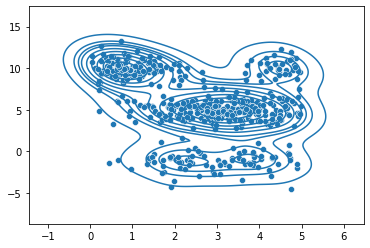

In [9]:
observation_value = posterior.samples[mixture].sel(sample=0).to_pandas()
sns.scatterplot(x=x_value, y=observation_value)
sns.kdeplot(x=x_value, y=observation_value)

In [10]:
kde_groundtruth = scipy.stats.gaussian_kde(np.vstack([x_value, observation_value]))

## Modelling the mixture weights with given x

In [11]:
x = x_gs.clone()
coefficients = la.links.scalar.Spline(
    x,
    output=w,
    label="coefficients",
    transforms=[la.transforms.Softmax(dimension=distributions_dim)],
    output_distribution=la.distributions.Normal(),
)
dist = la.distributions.Mixture(weight=coefficients, distributions=distributions_gs)
observation = la.Observation(observation_value, dist, label="observation")
observation.plot()

In [12]:
inference = la.infer.svi.SVI(
    observation, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(3000)

  0%|                                                                                                         …

In [13]:
posterior = la.posterior.scalar.ScalarObserved(observation, retain_samples = {observation.p, x})
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
assert posterior.likelihood / n_cells > -3

<AxesSubplot:>

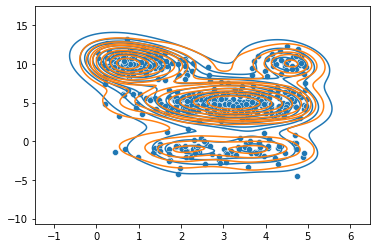

In [15]:
sns.scatterplot(x=x_value, y=observation_value)
sns.kdeplot(x=x_value, y=observation_value)

modelled_value = (
    posterior.samples[observation.p].stack(cells=("sample", "cell")).to_pandas()
)
modelled_x = posterior.samples[x].stack(cells=("sample", "cell")).to_pandas()
sns.kdeplot(x=modelled_x, y=modelled_value)

Quantitatively check whether the densities are modelled correctly

In [16]:
kde_modelled = scipy.stats.gaussian_kde(np.vstack([modelled_x, modelled_value]))
points = np.array(
    np.meshgrid(np.linspace(-1, 6, 20), np.linspace(-10, 15, 20))
).T.reshape(2, -1)

evaluated_modelled = kde_modelled.evaluate(points)
evaluated_groundtruth = kde_groundtruth.evaluate(points)

kl_divergence = (
    evaluated_groundtruth * (np.log(evaluated_groundtruth) - np.log(evaluated_modelled))
).sum()

np.sqrt(((evaluated_modelled - evaluated_groundtruth) ** 2).sum()) < 0.1

True

Assess how x changes the observation

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

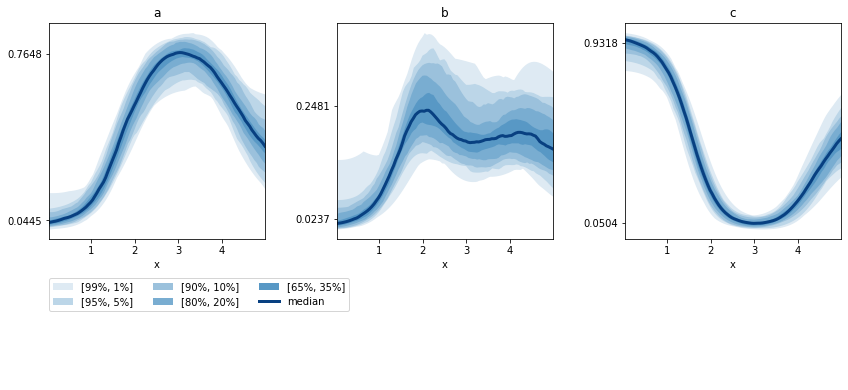

In [17]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.sample(100)
causal.observed.sample()

causal.plot_features();

## Modelling the mixture weights with latent x

A one-dimensional ouput is of course not enough to recapitulate an actual latent x. All we can do is to find an x that can distinguishes the 3 components

In [18]:
x = la.Latent(la.distributions.Uniform(0.0, 5.0), definition=x.value_definition)

In [19]:
coefficients = la.links.scalar.Spline(
    x,
    output=w,
    label="coefficients",
    transforms=[la.transforms.Softmax(dimension=distributions_dim)],
    step_distribution=la.distributions.Normal(),
)

In [20]:
dist = la.distributions.Mixture(weight=coefficients, distributions=distributions_gs)

In [21]:
observation = la.Observation(observation_value, dist, label="observation")

In [22]:
observation.plot()

In [23]:
inference = la.infer.svi.SVI(
    observation, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.01)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [24]:
posterior = la.posterior.scalar.ScalarObserved(observation, retain_samples = {observation.p, x})
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
assert posterior.likelihood / n_cells > -3

<AxesSubplot:>

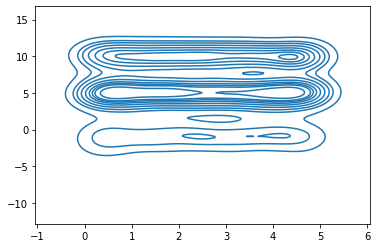

In [26]:
modelled_value = (
    posterior.samples[observation.p].stack(cells=("sample", "cell")).to_pandas()
)
modelled_x = posterior.samples[x].stack(cells=("sample", "cell")).to_pandas()
sns.kdeplot(x=modelled_x, y=modelled_value)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

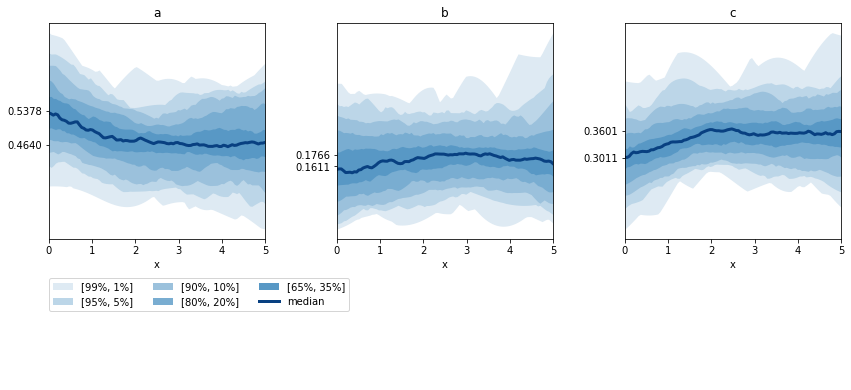

In [27]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.sample(100)
causal.observed.sample()

causal.plot_features();

## Modelling the mixture weights with given x and unknown distribution parameters

In [112]:
x = x_gs.clone()
distributions = {
    distribution_id: la.distributions.Normal(la.Parameter(0.0), la.Parameter(1.0), transforms = [la.transforms.Affine(a = 5.)])
    for distribution_id in "abc"
}
distributions_dim = la.Dim(distributions.keys(), "distribution")

coefficients = la.links.scalar.Spline(
    x,
    output=la.Definition([cells, distributions_dim]),
    label="coefficients",
    transforms=[la.transforms.Softmax(dimension=distributions_dim)],
    step_distribution = la.distributions.Normal(scale = 2.)
)
dist = la.distributions.Mixture(weight=coefficients, distributions=distributions)
observation = la.Observation(observation_value, dist, label="observation")
observation.plot()

In [124]:
inference = la.infer.svi.SVI(
    observation, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.001)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [125]:
{dist.loc.prior() for dist in distributions.values()}

{tensor(-0.2332, requires_grad=True),
 tensor(0.9927, requires_grad=True),
 tensor(1.9973, requires_grad=True)}

In [126]:
posterior = la.posterior.scalar.ScalarObserved(observation, retain_samples = {observation.p, x})
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [127]:
assert posterior.likelihood / n_cells > -3

<AxesSubplot:>

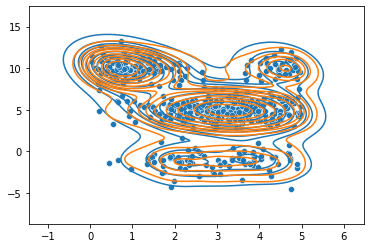

In [128]:
sns.scatterplot(x=x_value, y=observation_value)
sns.kdeplot(x=x_value, y=observation_value)

modelled_value = (
    posterior.samples[observation.p].stack(cells=("sample", "cell")).to_pandas()
)
modelled_x = posterior.samples[x].stack(cells=("sample", "cell")).to_pandas()
sns.kdeplot(x=modelled_x, y=modelled_value)

In [129]:
{dist.loc.prior() for dist in distributions.values()}

{tensor(-0.2332, requires_grad=True),
 tensor(0.9927, requires_grad=True),
 tensor(1.9973, requires_grad=True)}

Quantitatively check whether the densities are modelled correctly

In [130]:
kde_modelled = scipy.stats.gaussian_kde(np.vstack([modelled_x, modelled_value]))
points = np.array(
    np.meshgrid(np.linspace(-1, 6, 20), np.linspace(-10, 15, 20))
).T.reshape(2, -1)

evaluated_modelled = kde_modelled.evaluate(points)
evaluated_groundtruth = kde_groundtruth.evaluate(points)

kl_divergence = (
    evaluated_groundtruth * (np.log(evaluated_groundtruth) - np.log(evaluated_modelled))
).sum()

assert (evaluated_modelled - evaluated_groundtruth).sum() > -0.5

Assess how x changes the observation

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

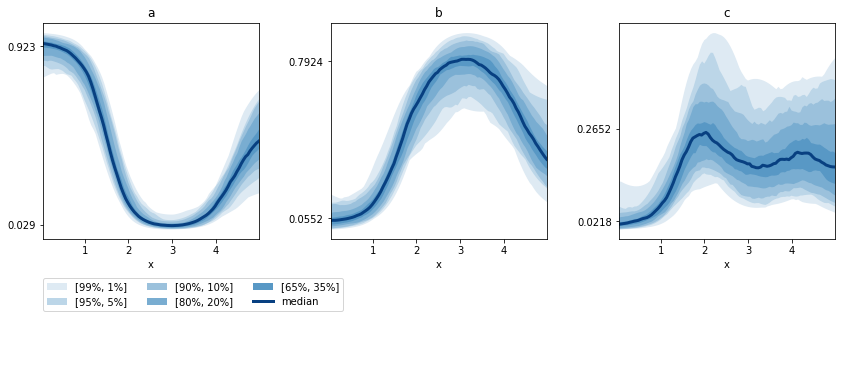

In [131]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.sample(100)
causal.observed.sample()

causal.plot_features();

## Modelling the mixture weights with given x and latent distribution parameters

In [62]:
x = x_gs.clone()
distribution_loc_p = la.distributions.Normal(scale=5.0)
distribution_scale_p = la.distributions.LogNormal(scale=2.0)
distributions = {
    distribution_id: la.distributions.Normal(
        la.Latent(distribution_loc_p), la.Latent(distribution_scale_p)
    )
    for distribution_id in "abc"
}
distributions_dim = la.Dim(distributions.keys(), "distribution")

coefficients = la.links.scalar.Spline(
    x,
    output=la.Definition([cells, distributions_dim]),
    label="coefficients",
    transforms=[la.transforms.Softmax(dimension=distributions_dim)],
    output_distribution=la.distributions.Normal(),
)
dist = la.distributions.Mixture(weight=coefficients, distributions=distributions)
observation = la.Observation(observation_value, dist, label="observation")
observation.plot()

In [63]:
inference = la.infer.svi.SVI(
    observation, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=0.05)
)
trainer = la.infer.trainer.Trainer(inference)
trace = trainer.train(10000)

  0%|                                                                                                         …

In [64]:
posterior = la.posterior.scalar.ScalarObserved(observation, retain_samples = {observation.p, x})
posterior.sample(10)

  0%|          | 0/10 [00:00<?, ?it/s]

In [65]:
assert posterior.likelihood / n_cells > -3

<AxesSubplot:>

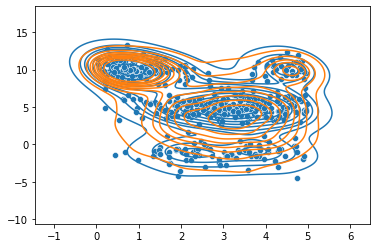

In [66]:
sns.scatterplot(x=x_value, y=observation_value)
sns.kdeplot(x=x_value, y=observation_value)

modelled_value = (
    posterior.samples[observation.p].stack(cells=("sample", "cell")).to_pandas()
)
modelled_x = posterior.samples[x].stack(cells=("sample", "cell")).to_pandas()
sns.kdeplot(x=modelled_x, y=modelled_value)

In [77]:
{dist.loc.q.loc.prior() for dist in distributions.values()}

{tensor(0.7007, requires_grad=True),
 tensor(0.7475, requires_grad=True),
 tensor(1.9848, requires_grad=True)}

<AxesSubplot:ylabel='Count'>

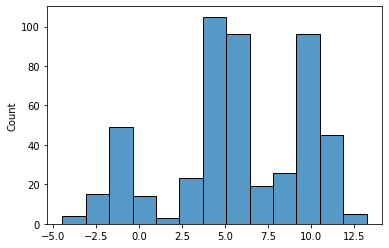

In [71]:
sns.histplot(observation_value)

Quantitatively check whether the densities are modelled correctly

In [70]:
kde_modelled = scipy.stats.gaussian_kde(np.vstack([modelled_x, modelled_value]))
points = np.array(
    np.meshgrid(np.linspace(-1, 6, 20), np.linspace(-10, 15, 20))
).T.reshape(2, -1)

evaluated_modelled = kde_modelled.evaluate(points)
evaluated_groundtruth = kde_groundtruth.evaluate(points)

kl_divergence = (
    evaluated_groundtruth * (np.log(evaluated_groundtruth) - np.log(evaluated_modelled))
).sum()

assert (evaluated_modelled - evaluated_groundtruth).sum() > -1.

Assess how x changes the observation

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

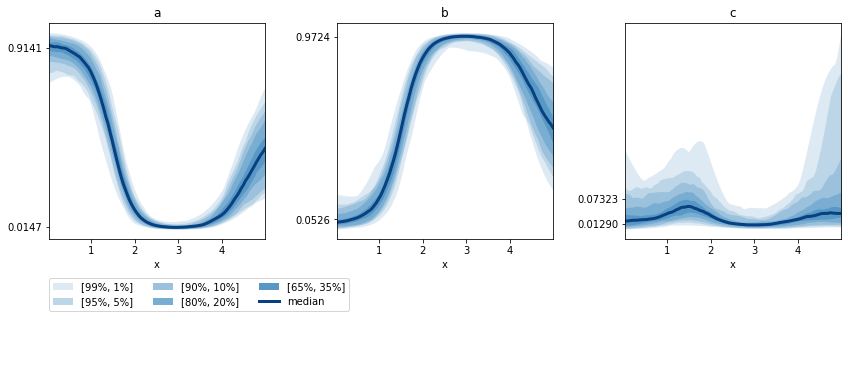

In [68]:
causal = la.posterior.scalar.ScalarVectorCausal(x, observation)
causal.sample(100)
causal.observed.sample()

causal.plot_features();